**Setup iniziale**

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from google.colab import drive
drive.mount('/content/drive')
cwd= 'drive/MyDrive/Colab Notebooks'
file_path= cwd + '/air_quality.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The CSV file was not found at the path: {file_path}")

# Carichiamo il dataset
# -> nrows indica il numero di righe massimo da caricare
# -> na_values contiene le stringhe del file che indicano valori assenti nelle celle (Pandas li sostituisce con un valore None)
df= pd.read_csv(file_path, low_memory=False, na_values=['-', 'NA', 'n/a', 'ND',''], nrows=1000000)

# LA COLONNA (o feature) 'aqi' (Air Quality Index) È IL TARGET DA PREDIRE (ovvero la nostra Y)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data cleaning**

Oltre ad eliminare le colonne completamente vuote e le righe che hanno il campo target vuoto:
* Convertiamo i valori delle colonne non numeriche 'county' e 'sitename' in valori numerici
* Selezioniamo le colonne numeriche ('numeric_cols_names')
* Eliminiamo anche le righe che hanno almeno un campo vuoto che rientra in 'numeric_cols_names'

In [8]:
"""
-> FACOLTATIVO
-> Qua mostriamo in output l'elenco delle colonne che hanno solo valori None (colonne completamente vuote)
empty_cols_names= df.columns[df.isna().all()].tolist()
print("Colonne rimosse perché completamente vuote:", empty_cols_names)
"""

# Codifichiamo con dei numeri i valori delle colonne non numeriche (categoriche: es. stringhe)
# Le colonne non numeriche che ci interessano per l'addestramento del modello sono 'county' e 'sitename'
county_encoder= LabelEncoder()
df["county"]= county_encoder.fit_transform(df["county"].astype(str))
sitename_encoder= LabelEncoder()
df["sitename"]= sitename_encoder.fit_transform(df["sitename"].astype(str))

# Puliamo il dataframe

# La funzione dropna() usa questi parametri:
# -> "axis" indica: 0=righe / 1=colonne
# -> "how" indica: 'all'="se tutti i valori sono nulli" / 'any'="se almeno un valore è nullo"
# -> "subset" indica di considerare solo i valori di certe colonne quando deve verificare se sono nulli
# -> "inplace=True" dice a Pandas di fare la modifica direttamente sull'oggetto (quindi le funzioni ritorneranno None)
df.dropna(axis=1, how='all', inplace=True) # Eliminiamo tutte le colonne che hanno tutti valori None (SOLO VALORI NULLI)

# Selezioniamo i nomi delle colonne con valori puramente numerici (ATTENZIONE: qua dentro ci sarà anche la nostra colonna target 'aqi' perché è numerica!
# Inoltre ci saranno anche le colonne 'county' e 'sitename' che abbiamo fatto diventare numeriche con un label encoding)
numeric_cols_names= df.select_dtypes(include=[np.number]).columns.tolist()
# Eliminiamo tutte le righe che hanno un valore None nei campi numerici (quindi in 'aqi' + gli altri numerici)
df.dropna(axis=0, how='any', subset=numeric_cols_names, inplace=True)

**Pre-processing**

Facciamo split del dataset per training e test.

In [9]:
# Definiamo X (le feature che il modello userà per fare la predizione)
# Scegliamo come X tutte le feature numeriche, però attenzione: se usiamo 'numeric_cols_names' dobbiamo prima togliere la colonna 'aqi' perché sarà la nostra Y!
numeric_cols_names.remove('aqi')
X= df[numeric_cols_names]
# Scegliamo come Y (la feature target che il modello dovrà predire) la feature 'aqi'
Y= df['aqi']

# Splittiamo:
# -> le righe presenti in X in: righe per l'addestramento (70%: X_train) + righe per il test (30%: X_test)
# -> le righe presenti in Y in: righe per l'addestramento (70%: Y_train) + righe per il test (30%: Y_test)
X_train, X_test, Y_train, Y_test= train_test_split(
    X, Y,
    test_size=0.3,   # 30% per il test e 70% per l'addestramento
    random_state=42  # Seme per cercare di ottenere ad ogni esecuzione un risultato simile (facoltativo)
)

**Model building e valutazione delle performance**

In [10]:
# Creiamo il modello
model= LinearRegression()
# Addestriamo il modello sui dati di train, ovvero:
# -> X_train
# -> Y_train (ovvero gli 'aqi' corrispondenti alle righe di X_train: sono le soluzioni della predizione che il modello userà per capire qual'è l''aqi' di una riga)
model.fit(X_train, Y_train)

# Testiamo quanto è diventato bravo il modello facendogli predire l''aqi' delle righe di X_test
Y_pred= model.predict(X_test) # Mettiamo i risultati di ogni predizione (una per ogni riga di X_test) in Y_pred

# Ora paragoniamo i valori predetti dal modello (ovvero Y_pred) con i valori reali (ovvero Y_test): in questo modo vediamo le sue performance (ovvero quanto è bravo)
# Usiamo 2 metriche di valutazione: Mean Squared Error (MSE), Root Mean Squared Error (RMSE)
mse= mean_squared_error(Y_test, Y_pred)  # La funzione mean_squared_error() ci da il MSE
rmse= root_mean_squared_error(Y_test, Y_pred) # La funzione root_mean_squared_error() ci da il RMSE

# Mostriamo il MSE ed il RMSE
print("\nPerformance del modello:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

"""
-> Facoltativo
print(f"RMSE on aqi range (%): {(rmse/(y_test.max()-y_test.min()))*100:.2f}")
"""


Performance del modello:
Mean Squared Error: 44.30
Root Mean Squared Error: 6.66


'\n-> Facoltativo\nprint(f"RMSE on aqi range (%): {(rmse/(y_test.max()-y_test.min()))*100:.2f}")\n'

**Mostriamo graficamente la differenza tra i valori reali ed i valori predetti**

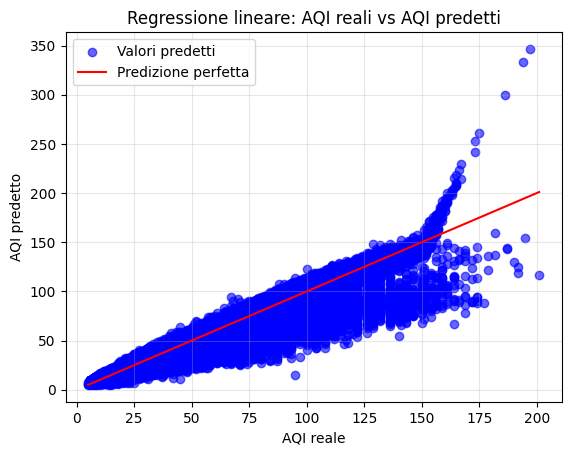

In [11]:
# Usiamo Matplotlib
# Stampiamo sull'asse X i valori reali di 'aqi' e sull'asse Y i valori predetti
plt.scatter(
    Y_test, # Valori dell'asse X
    Y_pred, # Valori corrispondenti sull'asse Y
    alpha=0.6, # Formattazione disegno
    color='blue', # Formattazione disegno
    label='Valori predetti' # Legenda
)
# Stampiamo una linea retta che rappresenta la predizione perfetta
plt.plot(
    [Y_test.min(), Y_test.max()],
    [Y_test.min(), Y_test.max()],
    color='red', # Formattazione disegno
    label='Predizione perfetta' # Legenda
)
plt.xlabel("AQI reale") # Titolo asse X
plt.ylabel("AQI predetto") # Titolo asse Y
plt.title("Regressione lineare: AQI reali vs AQI predetti") # Titolo disegno
plt.legend() # Visualizziamo la legenda
plt.grid(alpha=0.3) # Formattazione disegno
plt.show()